In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import time

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from numpyro.infer import SVI, Trace_ELBO, Predictive
import numpyro.diagnostics

from termcolor import colored
import matplotlib.pyplot as plt


import dill
import pickle
import arviz as az

#GP Kernel Function

In [ ]:
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)

In [ ]:
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)


#Aggregation Functions

In [ ]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

#Aggregated Prevalence Model - must edit this to include HDI, population density



In [ ]:
def prev_model_gp_aggr(args):
    """Dengue prevalence model with a Gaussian Process"""

    x = args["x"]  # Spatial grid points: (num_grid_points, 2)
    gp_kernel = args["gp_kernel"]  # Gaussian Process kernel
    noise = args["noise"]
    jitter = args["jitter"]

    pop_density = args["pop_density"]  # (num_districts,)
    hdi = args["hdi"]  # (num_districts,)
    M = args["M"]  # (num_districts, num_grid_points) aggregation matrix
    total_cases = args["total_cases"]
    total_population = args["total_population"]

    # GP hyperparameters
    kernel_length = numpyro.sample("kernel_length", args["kernel_length"])
    kernel_var = numpyro.sample("kernel_var", args["kernel_var"])

    # GP Kernel and Sample
    k = gp_kernel(x, x, kernel_var, kernel_length, noise, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))  # (num_grid_points,)

    # Aggregate GP values to district level
    gp_aggr = numpyro.deterministic("gp_aggr", M @ f)  # (num_districts,)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(0, 1))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI

    #standardise pop_density and hdi before passing to the linear function
    pop_density = (pop_density - jnp.mean(pop_density)) / jnp.std(pop_density)
    hdi = (hdi - jnp.mean(hdi)) / jnp.std(hdi)

    # Linear predictor
    lp = b0 + gp_aggr + b_pop_density * pop_density + b_hdi * hdi  # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp) * 1e-2)  # (num_districts,)

    # Binomial likelihood
    observed_cases = numpyro.sample(
        "observed_cases",
        dist.Binomial(total_count=total_population, probs=theta),
        obs=total_cases
    )

    return observed_cases


#Load Data

In [ ]:
# Lat/Lon Values of artificial grid
x = np.load("lat_lon_x_jkt.npy")

# combined regional data
pol_pts_jkt = np.load("pol_pts_jkt.npy")
pt_which_pol_jkt = np.load("pt_which_pol_jkt.npy")

#combine the dataframes
df_combined = gpd.read_file("jkt_combined_divisions.shp")

In [ ]:
#check columns
df_combined.head()

,District,x,y,Year,Area_sq_km,HDI,Cases,Population,Pop_den,geometry
0,KOTA JAKARTA BARAT,106.748403,-6.165609,2020,124.44,81.38,161,184826,1485.261974,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
1,KOTA JAKARTA BARAT,106.748403,-6.165609,2021,124.44,81.76,138,183270,1472.757956,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
2,KOTA JAKARTA BARAT,106.748403,-6.165609,2022,125.00,82.51,420,181715,1453.720000,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
3,KOTA JAKARTA BARAT,106.748403,-6.165609,2023,125.00,83.02,359,180159,1441.272000,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956..."
4,KOTA JAKARTA PUSAT,106.835076,-6.181230,2020,52.38,81.39,127,73140,1396.334479,"POLYGON ((106.83247 -6.14138, 106.83282 -6.141..."


#Vars needed to be changed (change according to the agg prevalence model parameters)

In [ ]:
M = jnp.array(pol_pts_jkt)
pop_density = jnp.array(df_combined["Pop_den"])
hdi = jnp.array(df_combined["HDI"])
test_cases = jnp.array(df_combined["Total Population"])
cases = jnp.array(df_combined["Total Cases"])

In [ ]:
#print the shape of all the vars above
print(M.shape)
print(pop_density.shape)
print(hdi.shape)
print(test_cases.shape)
print(cases.shape)
print(x.shape)
print(pt_which_pol_jkt.shape)

(20, 100)
(20,)
(20,)
(20,)
(20,)
(100, 2)
(100,)


#Agg GP Model

In [ ]:
 args = {
        "x" : jnp.array(x), # Lat/lon vals of grid points # Shape (num_districts, 2)
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        "M" : jnp.array(pol_pts_jkt), # Aggregation matrix # Shape (num_districts, num_districts)
        # GP Kernel Hyperparams
        "kernel_length" : dist.InverseGamma(3,3), #(,)
        "kernel_var" : dist.HalfNormal(1e-5),
        "pop_density": jnp.array(df_combined["Pop_den"]), # Shape (num_districts,)
        "hdi": jnp.array(df_combined["HDI"]), # Shape (num_districts, 2)
        "total_cases" : jnp.array(df_combined["Total Cases"]),
        "total_population" : jnp.array(df_combined["Total Population"])
    }


#Run MCMC

In [ ]:
# 🔹 Random keys
run_key, predict_key = random.split(random.PRNGKey(3))

# 🔹 MCMC settings
n_warm = 1000
n_samples = 2000
n_chains = 4


In [ ]:
# 🔹 Directory for saving
save_dir = "model_weights"
os.makedirs(save_dir, exist_ok=True)

#Save Model

In [ ]:
# Initialize MCMC
mcmc = MCMC(NUTS(prev_model_gp_aggr),
        num_warmup=n_warm,
        num_samples=n_samples,
        num_chains=4)


# Run the chain
start = time.time()
mcmc.run(run_key, args)
end = time.time()
t_elapsed_min = round((end - start) / 60)

# 🔹 Save after each chain completes
f_path = f"{save_dir}/aggGP_4chains_nsamples_{n_samples}_tt{t_elapsed_min}min_scaled1e-2.pkl"
with open(f_path, "wb") as file:
    dill.dump(mcmc, file)

print(f"✅ Saved aggGP to {f_path}")
print(f"⏳ Time taken: {t_elapsed_min} min\n")

<ipython-input-82-808dfd89ea7b>:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(prev_model_gp_aggr),
sample: 100%|██████████| 3000/3000 [00:39<00:00, 76.22it/s, 15 steps of size 2.98e-01. acc. prob=0.89]


✅ Saved aggGP to model_weights/aggGP_4chains_nsamples_2000_tt3min_scaled1e-2.pkl
⏳ Time taken: 3 min



In [ ]:
samples = mcmc.get_samples()

In [ ]:
#view the theta
samples["theta"]

Array([[0.00143751, 0.00150373, 0.00163825, ..., 0.00170891, 0.00179854,
        0.00185443],
       [0.00131047, 0.0013769 , 0.00151486, ..., 0.00182852, 0.00191041,
        0.00197816],
       [0.00131439, 0.00137933, 0.00151169, ..., 0.00171888, 0.00181596,
        0.00187501],
       ...,
       [0.00138843, 0.0014556 , 0.00159452, ..., 0.00177858, 0.00185673,
        0.00192042],
       [0.00137067, 0.00143471, 0.00156543, ..., 0.00192787, 0.00202225,
        0.00208465],
       [0.00139062, 0.00145621, 0.00159198, ..., 0.00170837, 0.00177973,
        0.00184041]], dtype=float32)

In [ ]:
#assess the R hat, ESS etc.,
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain = True))
r = np.mean(ss["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r)}")
print(f"Max r_hat for all aggGP low effects : {str(round(np.max(ss['gp_aggr']['r_hat']),2))}")
print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")

Average ESS for all aggGP effects : 4239
Max r_hat for all aggGP low effects : 1.0
kernel_length R-hat : 1.0
kernel_var R-hat : 1.0


In [ ]:
mcmc.print_summary(exclude_deterministic = False)


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -1.48      0.04     -1.48     -1.55     -1.41   2705.53      1.00
          b_hdi      0.22      0.03      0.22      0.18      0.26  11575.91      1.00
  b_pop_density     -0.07      0.03     -0.07     -0.12     -0.02   7580.81      1.00
           f[0]     -0.00      0.01     -0.00     -0.03      0.02  14681.86      1.00
           f[1]     -0.00      0.01     -0.00     -0.03      0.02  16486.33      1.00
           f[2]     -0.00      0.01     -0.00     -0.03      0.02  15940.57      1.00
           f[3]     -0.00      0.01     -0.00     -0.02      0.02  17135.20      1.00
           f[4]     -0.00      0.01     -0.00     -0.02      0.02  14027.74      1.00
           f[5]     -0.00      0.01     -0.00     -0.02      0.02  16151.30      1.00
           f[6]     -0.00      0.01     -0.00     -0.02      0.02  14722.42      1.00
           f[7]     -0.00      0.01     -0.00     -0.

array([[<Axes: title={'center': 'kernel_var'}>,
        <Axes: title={'center': 'kernel_var'}>]], dtype=object)

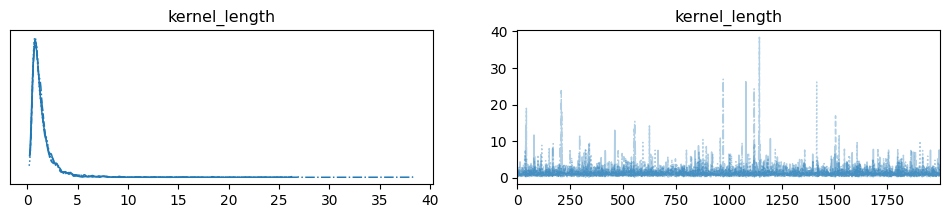

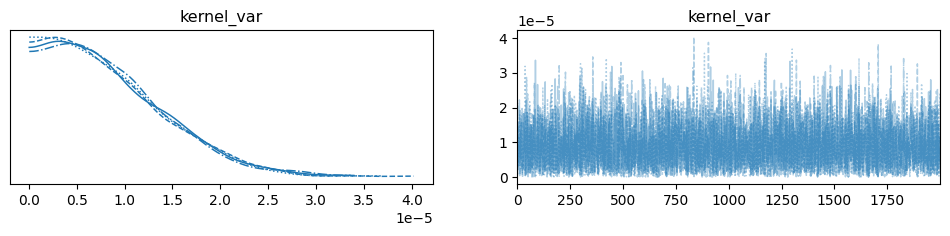

In [ ]:
case_samples_az_gp_lo = az.from_numpyro(mcmc)
az.plot_trace(case_samples_az_gp_lo, var_names = ("kernel_length"))
az.plot_trace(case_samples_az_gp_lo, var_names = ("kernel_var"))

### Calculate and append observed and gp-estimated theta

In [ ]:
samples["theta"].shape

(8000, 20)

In [ ]:
theta_mean_gp = samples["theta"].mean(axis = 0)
bci_gp_25 = np.quantile(samples["theta"],0.25,axis = 0)
bci_gp_75 = np.quantile(samples["theta"],0.75, axis = 0)

df_combined["theta_gp"] = theta_mean_gp
#df["estimate"] <- NOT available
# Calculate Prevelance
df_combined["obs_prev"] = df_combined["Cases"] / df_combined["Population"]

theta_obs = df_combined["obs_prev"]
theta_gp_est = df_combined["theta_gp"]
max_val = np.max([theta_obs, theta_gp_est])
min_val = np.min([theta_obs, theta_gp_est])

In [ ]:
df_combined.head()

,District,x,y,Year,Area_sq_km,HDI,Cases,Population,Pop_den,geometry,theta_gp,obs_prev
0,KOTA JAKARTA BARAT,106.748403,-6.165609,2020,124.44,81.38,161,184826,1485.261974,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956...",0.001387,0.000871
1,KOTA JAKARTA BARAT,106.748403,-6.165609,2021,124.44,81.76,138,183270,1472.757956,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956...",0.001456,0.000753
2,KOTA JAKARTA BARAT,106.748403,-6.165609,2022,125.00,82.51,420,181715,1453.720000,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956...",0.001599,0.002311
3,KOTA JAKARTA BARAT,106.748403,-6.165609,2023,125.00,83.02,359,180159,1441.272000,"POLYGON ((106.70503 -6.0956, 106.70526 -6.0956...",0.001702,0.001993
4,KOTA JAKARTA PUSAT,106.835076,-6.181230,2020,52.38,81.39,127,73140,1396.334479,"POLYGON ((106.83247 -6.14138, 106.83282 -6.141...",0.001586,0.001736


###Plot the map

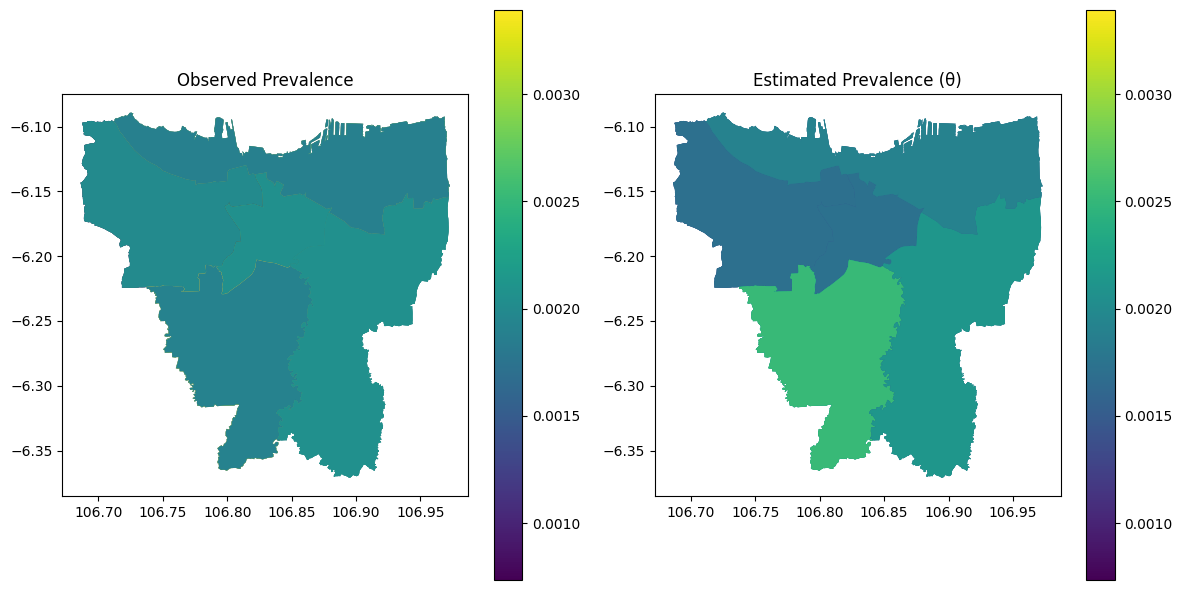

<Figure size 800x600 with 0 Axes>

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot observed prevalence on the map
df_combined.plot(
    column="obs_prev",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val,  # Minimum value for color scale
    vmax=max_val,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[0],  # Plot on the first subplot
)
ax[0].set_title("Observed Prevalence")

# Plot estimated prevalence on the map
df_combined.plot(
    column="theta_gp",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val,  # Minimum value for color scale
    vmax=max_val,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[1],  # Plot on the second subplot
)
ax[1].set_title("Estimated Prevalence (θ)")

# Save the plot
plt.savefig("observed_vs_estimated_prevalence.png")  # Save as PNG
# Or save as PDF:
# plt.savefig("observed_vs_estimated_prevalence.pdf")

plt.tight_layout()
plt.show()

#save the plot
plt.figure(figsize=(8, 6))

plt.show()

###Plot scatterplot

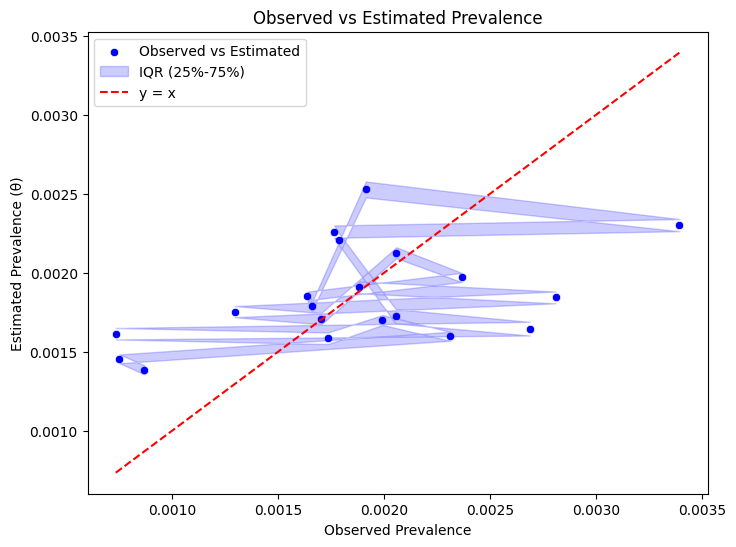

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert JAX arrays to NumPy arrays before plotting
theta_obs = np.asarray(df_combined["obs_prev"])
theta_gp_est = np.asarray(df_combined["theta_gp"])
bci_gp_25 = np.asarray(bci_gp_25)
bci_gp_75 = np.asarray(bci_gp_75)

# Compute min and max for plot limits
_max = max(theta_obs.max(), theta_gp_est.max())
_min = min(theta_obs.min(), theta_gp_est.min())

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter plot of observed vs estimated prevalence
sns.scatterplot(x=theta_obs, y=theta_gp_est, label="Observed vs Estimated", color="blue")

# Add IQR shaded region
plt.fill_between(theta_obs, bci_gp_25, bci_gp_75, color="blue", alpha=0.2, label="IQR (25%-75%)")

# Plot reference line (y = x) for comparison
sns.lineplot(x=[_min, _max], y=[_min, _max], color="red", linestyle="--", label="y = x")

#save figure
plt.savefig("observed_vs_estimated_prevalence_scatter.png")

# Labels and title
plt.xlabel("Observed Prevalence")
plt.ylabel("Estimated Prevalence (θ)")
plt.title("Observed vs Estimated Prevalence")
plt.legend()
plt.show()

In [ ]:
#save df
df_combined.to_csv("df_with_gp_preds_simulation.csv")
df_combined.to_file("df_with_gp_preds_simulation.shp")